# Import Library

In [28]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from collections import Counter


# Data Preprocessing

In [29]:
data_dir = 'Data/data/The IQ-OTHNCCD lung cancer dataset/'

categories = ['bengin', 'malignant', 'normal']

def preprocess_image(file_path):
    img = cv2.imread(file_path, 3)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Chuẩn hóa pixel trong khoảng [0, 1]
    return img

data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

data, labels = shuffle(data, labels, random_state=42)

# Kiểm tra cân bằng dữ liệu
print('Data length:', len(data))
print('labels counts:', Counter(labels))

# normalize
X = np.array(data).reshape(-1, 224, 224, 3)
y = np.array(labels)

Data length: 1097
labels counts: Counter({1: 561, 2: 416, 0: 120})


# Split Data

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 767 (767, 224, 224, 3)
Test length: 330 (330, 224, 224, 3)


# Data Augmentation

In [31]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)


# Build AlexNet Model

In [32]:
def AlexNet(input_shape=(224,224,3)):
        inp = Input(input_shape)
        # 1st Convolutional Layer
        x = Conv2D(96,11,4, activation='relu', padding='valid',kernel_initializer='he_normal')(inp)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # 2st Convolutional Layer
        x = Conv2D(256,5,1, activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # 3st Convolutional Layer
        x = Conv2D(384,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # 4st Convolutional Layer
        x = Conv2D(384,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # 5st Convolutional Layer
        x = Conv2D(256,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # Passing it to a Fully Connected layer
        x = Flatten()(x)
        # 1st fully connected layer has 4096 neurons
        x = Dense(4096, activation='relu')(x)
        # Add Dropout to prevent overfitting
        x = Dropout(0.5)(x)
        # 2nd fully connected layer
        x = Dense(4096, activation='relu')(x)
        # Add droupout
        x = Dropout(0.5)(x)
        # Output layer
        x = Dense(3, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        return model

model = AlexNet()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 384)         8851

In [33]:
# Create an EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 3 consecutive epochs.
callback = EarlyStopping(monitor='val_loss', patience=3)

# Compile model

In [34]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Traning model

In [35]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

Epoch 1/20
96/96 [==============================] - 56s 532ms/step - loss: 1.5498 - accuracy: 0.4772 - val_loss: 0.9504 - val_accuracy: 0.5455
Epoch 2/20
96/96 [==============================] - 55s 571ms/step - loss: 0.9674 - accuracy: 0.4720 - val_loss: 0.9595 - val_accuracy: 0.5455
Epoch 3/20
96/96 [==============================] - 57s 589ms/step - loss: 0.9616 - accuracy: 0.4707 - val_loss: 0.9520 - val_accuracy: 0.5455
Epoch 4/20
96/96 [==============================] - 55s 573ms/step - loss: 0.9663 - accuracy: 0.4850 - val_loss: 0.9698 - val_accuracy: 0.5455


# Model Evaluation

In [36]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

11/11 [==============================] - 2s 170ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.55      1.00      0.71       180
           2       0.00      0.00      0.00       111

    accuracy                           0.55       330
   macro avg       0.18      0.33      0.24       330
weighted avg       0.30      0.55      0.39       330

[[  0  39   0]
 [  0 180   0]
 [  0 111   0]]


c:\Users\FPTSHOP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FPTSHOP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FPTSHOP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

# Graph

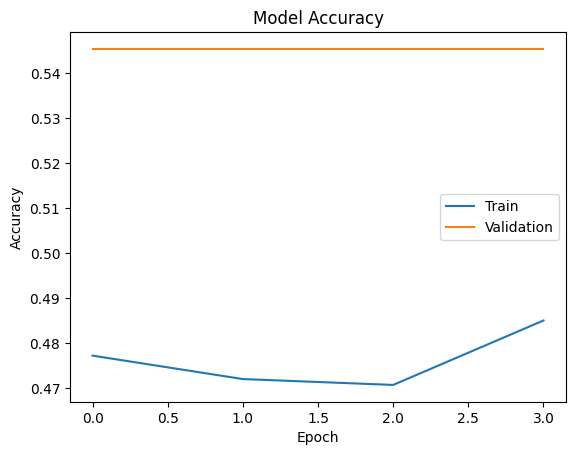

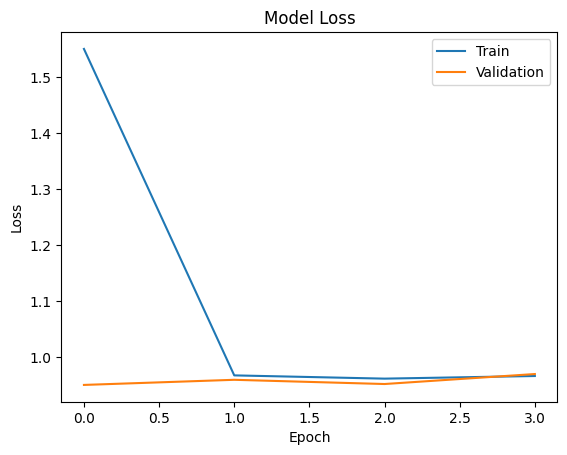

In [37]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()